In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import pickle

def save_pkl(filename, data):
    with open(f"./settings/{filename}.pkl", "wb") as f:
        pickle.dump(data, f)

def read_pkl(filename):
    with open(f"./settings/{filename}.pkl", "rb") as f:
        return pickle.load(f)

In [3]:
%matplotlib inline
mpl.style.use('dark_background')

In [4]:
pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 90)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [5]:
data = pd.read_csv("./data/survey_results_public.csv")

In [6]:
print(data.shape)
data.head()

(73268, 79)


,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,"32,000.00",Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,"40,205.00"
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,"60,000.00",Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trell

In [7]:
df = data[[
    'Employment',
    'Country',
    'EdLevel',
    'YearsCodePro',
    'Currency',
    'CompFreq',
    'CompTotal',
    'Age']]

In [8]:
df = df.dropna(axis=0)

In [9]:
countries = df['Country'].value_counts()[df['Country'].value_counts(normalize=True) >= 0.02].index
df = df[df["Country"].isin(countries)]

df["Country"] = df["Country"].map(lambda x: "United Kingdom" if x == "United Kingdom of Great Britain and Northern Ireland" else x)

df["Currency"] = df["Currency"].map(lambda x: x[:3])

In [10]:
df = df[df['Employment'] == "Employed, full-time"]
df = df.drop("Employment", axis=1)

In [11]:
if not os.path.exists("settings/rates.pkl"):

    from forex_python.converter import CurrencyRates, RatesNotAvailableError

    currency_rate = CurrencyRates()

    rates = {}
    for c in df["Currency"].unique():
        try:
            rates[c] = currency_rate.get_rate('USD', c)
        except RatesNotAvailableError:
            rates[c] = np.nan
    
    save_pkl("rates", data=rates)
else:
    rates = read_pkl("rates")

In [12]:
freq = {"Yearly": 1, "Monthly": 12, "Weekly": 4*12}
# df["Salary"] = df["CompTotal"] * df["Currency"].map(lambda x: rates[x]) * df["CompFreq"].map(lambda x: freq[x])
df["Salary"] = df["CompTotal"] * df["Currency"].map(lambda x: rates[x])

In [13]:
df = df.dropna(axis=0)

In [14]:
print(df.shape)
df.head()

(21377, 8)


,Country,EdLevel,YearsCodePro,Currency,CompFreq,CompTotal,Age,Salary
2,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5,GBP,Yearly,"32,000.00",25-34 years old,"27,049.87"
8,Netherlands,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,EUR,Yearly,"46,000.00",25-34 years old,"45,967.82"
10,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,GBP,Yearly,"48,000.00",18-24 years old,"40,574.80"
12,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,USD,Yearly,"65,000.00",25-34 years old,"65,000.00"
21,Italy,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,EUR,Yearly,"32,000.00",25-34 years old,"31,977.62"


In [15]:
df = df[df["Salary"] <= 1e+6]
df = df.apply(lambda row: row[~df['YearsCodePro'].isin(['Less than 1 year','More than 50 years'])])

In [16]:
df["YearsCodePro"] = pd.to_numeric(df["YearsCodePro"])

<AxesSubplot:xlabel='Country'>

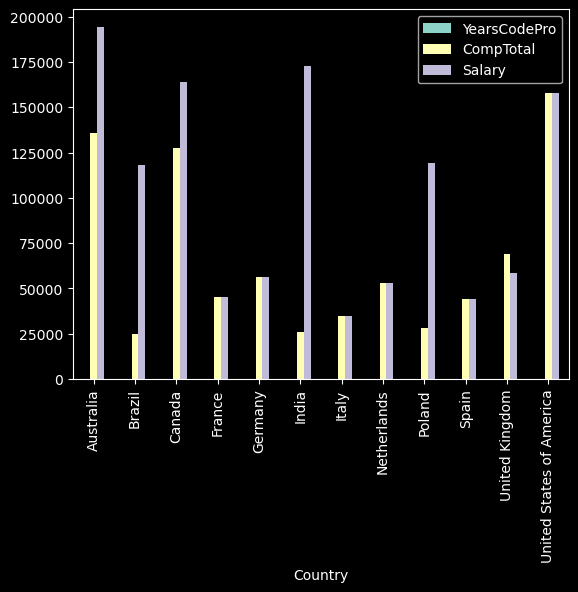

In [17]:
df.groupby("Country").mean().plot.bar()

In [18]:
def clean_education(x):
    if "Master’s degree" in x:
        return "Master"
    elif "Bachelor’s degree" in x:
        return "Bachelor"
    elif "Associate degree" in x:
        return "Associate"
    elif "Professional degree" in x or "Other doctoral degree" in x:
        return "Other"
    return "High school"

df["EdLevel"] = df["EdLevel"].map(clean_education)

In [19]:
df = df.loc[(df['Age'] != 'Under 18 years old') & (df['Age'] != 'Prefer not to say')]
df["age_category"] = df["Age"].astype("category").cat.codes

In [20]:
age_category = {v: df["Age"].unique()[i] for i, v in enumerate(df["age_category"].unique())}

In [21]:
categories = {
    "age": age_category,
    "education": list(df["EdLevel"].unique()),
    "countries": list(df["Country"].unique()),
}
save_pkl("categories", data=categories)

In [22]:
print(df.shape)
df.head()

(18722, 9)


,Country,EdLevel,YearsCodePro,Currency,CompFreq,CompTotal,Age,Salary,age_category
2,United Kingdom,Master,5,GBP,Yearly,"32,000.00",25-34 years old,"27,049.87",1
8,Netherlands,Master,6,EUR,Yearly,"46,000.00",25-34 years old,"45,967.82",1
10,United Kingdom,Bachelor,2,GBP,Yearly,"48,000.00",18-24 years old,"40,574.80",0
12,United States of America,Bachelor,5,USD,Yearly,"65,000.00",25-34 years old,"65,000.00",1
21,Italy,Master,4,EUR,Yearly,"32,000.00",25-34 years old,"31,977.62",1


In [23]:
df.to_csv("./data/survey_results_cleaned.csv", index=False)

In [24]:
X = df.drop(["CompTotal", "CompFreq", "Currency", "Salary", "Age"], axis=1)
y = df['Salary']

In [25]:
X.head()

,Country,EdLevel,YearsCodePro,age_category
2,United Kingdom,Master,5,1
8,Netherlands,Master,6,1
10,United Kingdom,Bachelor,2,0
12,United States of America,Bachelor,5,1
21,Italy,Master,4,1


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [29]:
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features  = make_column_selector(dtype_exclude=np.number)

In [30]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features)
)

In [31]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

In [32]:
models = {
    'SGD': make_pipeline(preprocessor, SGDRegressor()),
    'SVR': make_pipeline(preprocessor, SVR()),
    'Tree': make_pipeline(preprocessor, DecisionTreeRegressor()),
    'RandomForest': make_pipeline(preprocessor, RandomForestRegressor())
}

In [33]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name, model.score(X_test, y_test))
    
    # Mean Error
    error = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    print(f"{name}: ${error:,.02f}")

SGD 0.32033975920497704
SGD: $79,485.63
SVR -0.03757441520968974
SVR: $98,209.23
Tree 0.0896801483718942
Tree: $91,989.80
RandomForest 0.18204933057907502
RandomForest: $87,197.94


from sklearn.model_selection import learning_curve

N, train_scores, test_scores = learning_curve(
    models['SGD'], X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 500), cv=5
)

plt.figure(figsize=(12, 5))
plt.plot(N, test_scores.mean(axis=1), label='test')
plt.plot(N, train_scores.mean(axis=1), label='train')
plt.xlabel("train_sizes")
plt.legend()

In [34]:
from sklearn.model_selection import RandomizedSearchCV

In [35]:
sgd_params = {
    'sgdregressor__alpha': 10.0 ** -np.arange(1, 7),
    'sgdregressor__penalty': ['l2', 'l1'],
    'sgdregressor__learning_rate': ['constant', 'optimal', 'invscaling'],
    'sgdregressor__max_iter': [1500, 2000, 2500]
}

In [36]:
forest_params = {
    'randomforestregressor__n_estimators':  [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'randomforestregressor__max_features': ["sqrt", "log2", 1.0],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
         }

In [37]:
grid = RandomizedSearchCV(models["SGD"], param_distributions=sgd_params, n_iter=100, cv=5)

In [38]:
grid.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter t

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x285367970>),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x285367ca0>)])),
                                             ('sgdregressor', SGDRegressor())]),
                   n_iter=100,
                   param_distributions={'sgdregressor__alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                                        'sgdregressor__learning_rate': ['constant',
                                                                        'optimal',
                                                                        'invscaling'],
                                        'sgdregressor__max_iter': [1500, 2000,
                                                                   2500],
                                        'sgdregressor__penalty': ['l2', 'l1']})

In [39]:
print(f"Best Params: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

Best Params: {'sgdregressor__penalty': 'l1', 'sgdregressor__max_iter': 1500, 'sgdregressor__learning_rate': 'invscaling', 'sgdregressor__alpha': 1e-06}
Best Score: 0.27904797372769347


In [40]:
data = {"model": models["SGD"], "grid_model": grid.best_estimator_, "model_columns": X.columns}
save_pkl("saved_steps", data=data)

In [41]:
X.head()

,Country,EdLevel,YearsCodePro,age_category
2,United Kingdom,Master,5,1
8,Netherlands,Master,6,1
10,United Kingdom,Bachelor,2,0
12,United States of America,Bachelor,5,1
21,Italy,Master,4,1


In [42]:
data = read_pkl("saved_steps")
regressor = data['model']
grid_regressor = data['grid_model']

new_1 = pd.DataFrame(np.array([["United States of America", "Master", 6, 1]]), columns=data["model_columns"])
new_2 = pd.DataFrame(np.array([["United States of America", "Bachelor", 10, 1]]), columns=data["model_columns"])

for new_ in (new_1, new_2):
    y_pred = regressor.predict(new_)
    y_pred_grid = grid_regressor.predict(new_)
    print(y_pred)
    print(y_pred_grid)

[161297.12860399]
[162119.76075772]
[156994.67611846]
[157707.04030553]


In [43]:
usa = df.query("""`Country` == "United States of America" and `Age` == "25-34 years old" """)

<Figure size 1000x2000 with 0 Axes>

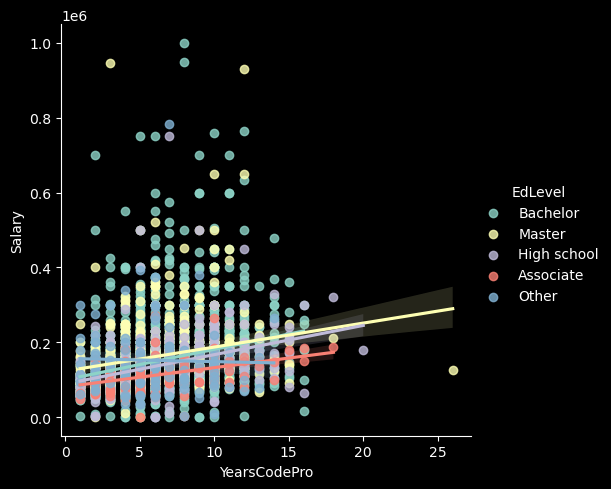

In [44]:
plt.figure(figsize=(10, 20))
sns.lmplot(
    x="YearsCodePro",
    y="Salary",
    data=usa,
    hue="EdLevel"
)
plt.show()